In [12]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
%matplotlib inline

Instead of using a numerical or analytical solution instead fit a simple damped sine curve to the data and then analyse the fitting coefficients

In [13]:
def func(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.sin(c*x+d) + e

In [14]:
def multianalyse(filenames, plot=True, prnt=True):
    ts = []
    ys = []
    for filename in filenames:
        t, x, y = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
        # incase we need to skip data points,
        # less useful for large datasets 
        # or when using for many different files
        skip = 0
        y = y[skip:]
        t = t[skip:] - t[skip]
        ys.extend(y)
        ts.extend(t)
    y = np.array(ys)
    t = np.array(ts)
    # sort t, sort y in same way
    way = t.argsort()
    t = t[way]
    y = y[way]
    # errors are currently quite ill defined
    ### could use a damped cosine curve for the error?
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(func, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        plt.figure()
        plt.scatter(t, y, label=f"{filename[:-2]}")
        plt.plot(t, func(t, *P[0]), color="r", label="Decaying Sine Curve")
        plt.legend()
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])
    
def analyse(filename, plot=True, prnt=True, ax=None):
    t, x, y = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
    # incase we need to skip the first few datapoints
    skip = 0
    y = y[skip:]
    t = t[skip:] - t[skip]
    ### see comment in multi analyse about errors
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(func, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            ax = plt.figure()
        plt.scatter(t, y, label=f"{filename}")
        plt.plot(t, func(t, *P[0]), color="r", label="Decaying Sine Curve")
        plt.legend()
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])
    


Combine the 3 sets of data for each percentage into one set and analyse. This results in smaller errors and the fitting appears to be better. 70% is still a problem though this is mostly due to it not having an actual frequency as there are very few oscillations.

The initial data collection (contructing vals) is due to missing the 30% data files. Once uploaded this can be cleaned up.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

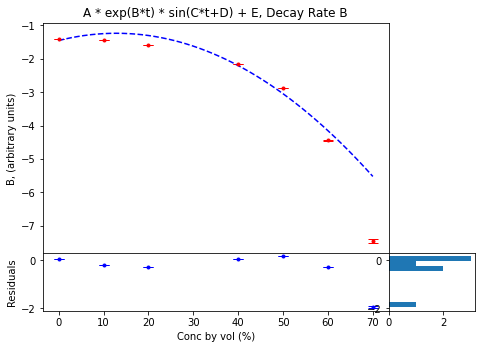

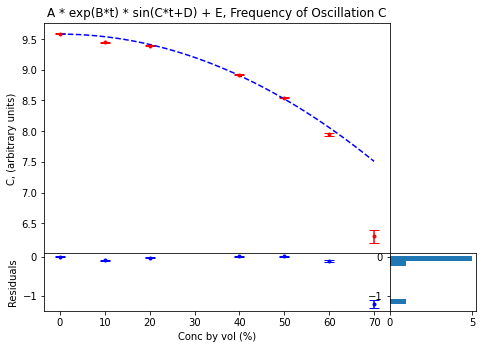

In [15]:
vals = []
for perc in range(0, 30, 10):
    v = []
    ax = plt.figure()
    ps = multianalyse([f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"], False, False)
    v.append(ps)
    vals.append(v)
for perc in range(40, 80, 10):
    v = []
    ax = plt.figure()
    ps = multianalyse([f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"], False, False)
    v.append(ps)
    vals.append(v)
vals=np.array(vals)
conc = np.array([[x] for x in range(0, 30, 10)] + [[x] for x in range(40, 80, 10)]).flatten()

# take all data sets, take the 0th element (3 videos combined into 1),
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
As = abs(vals[:, 0, 0, 0]).flatten()
Aerr = vals[:, 0, 1, 0].flatten()
Bs = vals[:, 0, 0, 1].flatten()
Berr = vals[:, 0, 1, 1].flatten()
Cs = abs(vals[:, 0, 0, 2]).flatten()
Cerr = vals[:, 0, 1, 2].flatten()
Ds = vals[:, 0, 0, 3].flatten()
Derr = vals[:, 0, 1, 3].flatten()
Es = vals[:, 0, 0, 4].flatten()
Eerr = vals[:, 0, 1, 4].flatten()

def fitter(x, a, b, c):
    return a*x**2+b*x+c

def plotCoeff(x, y, yerr, title_="", ylabel_=""):
    fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=(1,1,1), sigma=yerr, absolute_sigma=True)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, pfit[0], pfit[1], pfit[2])
    
    #first main axis with data and fit
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    ax1.set_title("A * exp(B*t) * sin(C*t+D) + E, " + title_)
    ax1.set_xlabel("Conc by vol (%)")
    ax1.set_ylabel(ylabel_)

    #residuals
    xs = x
    yres = y - fitter(xs, *pfit)
    ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
    ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
    ax2.set_xlabel("Conc by vol (%)")
    ax2.set_ylabel("Residuals")

    #histogram
    ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
    ax3.hist(x=yres, bins=10, orientation="horizontal")
    #fig.align_labels()

#Only interesting plots are B and C, others are variables to translate the model around to fit
#plot Bs
# Decay Rate, interesting negative correlation
plotCoeff(conc, Bs, Berr, "Decay Rate B","B, (arbitrary units)")

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
plotCoeff(conc, Cs, Cerr, "Frequency of Oscillation C", "C, (arbitrary units)")

Keep the 3 sets of data for each percentage separate and analyse. 70% is a problem though this is mostly due to it not having an actual frequency as there are very few oscillations.

The initial data collection (contructing vals) is due to missing the 30% data files. Once uploaded this can be cleaned up. (ie delete second loop and increase first to 80 from 30)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

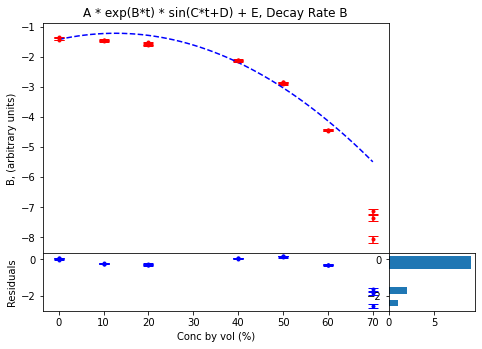

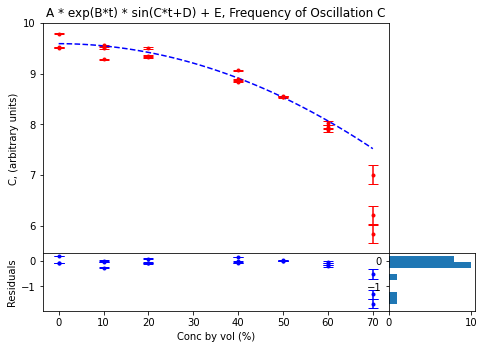

In [16]:
vals = []
for perc in range(0, 30, 10):
    v = []
    ax = plt.figure()
    for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
        ps = analyse(file, False, False, ax)
        v.append(ps)
    vals.append(v)
for perc in range(40, 80, 10):
    v = []
    ax = plt.figure()
    for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
        ps = analyse(file, False, False, ax)
        v.append(ps)
    vals.append(v)
vals=np.array(vals)
conc = np.array([[x,x,x] for x in range(0, 30, 10)] + [[x,x,x] for x in range(40, 80, 10)]).flatten()

# take all data sets, take all 3 videos,
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
As = abs(vals[:, :, 0, 0]).flatten()
Aerr = vals[:, :, 1, 0].flatten()
Bs = vals[:, :, 0, 1].flatten()
Berr = vals[:, :, 1, 1].flatten()
Cs = abs(vals[:, :, 0, 2]).flatten()
Cerr = vals[:, :, 1, 2].flatten()
Ds = vals[:, :, 0, 3].flatten()
Derr = vals[:, :, 1, 3].flatten()
Es = vals[:, :, 0, 4].flatten()
Eerr = vals[:, :, 1, 4].flatten()

def fitter(x, a, b, c):
    return a*x**2+b*x+c

def plotCoeff(x, y, yerr, title_="", ylabel_=""):
    fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=(1,1,1), sigma=yerr, absolute_sigma=True)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, pfit[0], pfit[1], pfit[2])
    
    # main data and model plot
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    ax1.set_title("A * exp(B*t) * sin(C*t+D) + E, " + title_)
    ax1.set_xlabel("Conc by vol (%)")
    ax1.set_ylabel(ylabel_)

    #residuals
    xs = x
    yres = y - fitter(xs, *pfit)
    ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
    ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
    ax2.set_xlabel("Conc by vol (%)")
    ax2.set_ylabel("Residuals")

    #histogram
    ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
    ax3.hist(x=yres, bins=8, orientation="horizontal")

#plot As 
# Function of Initial Depth, uninteresting for current experiment
#plotCoeff(conc, As, Aerr, "Maximum Amplitude A", "A, (arbitrary units)")

#plot Bs
# Decay Rate, interesting negative correlation
plotCoeff(conc, Bs, Berr, "Decay Rate B","B, (arbitrary units)")

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
plotCoeff(conc, Cs, Cerr, "Frequency of Oscillation C", "C, (arbitrary units)")

#plot Ds
# Phase shift, uninteresting in all.
#plotCoeff(conc, Ds, Derr, "Phase Shift D", "D, (arbitrary units)")

#Plot Es
# A shift of the axes, uninteresting
#plotCoeff(conc, Es, Eerr, "Zero-point Shift E", "E, (arbitrary units)")